### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance, plot_partial_dependence

from stratx.partdep import plot_catstratpd, plot_catstratpd_gridsearch, plot_stratpd, plot_stratpd_gridsearch

plt.style.use("seaborn-talk")

In [3]:
from why import data, preprocessing

In [4]:
config_file = Path.cwd() / ".." / "resources" / "carinsurance.json"
with open(config_file, mode="r") as f:
    config = json.load(f)

### Read the training and test data

In [5]:
insurance_data = data.CarInsurance(
    config=config, datapath=Path.cwd() / ".." / "data" / "raw"
)
train, test = insurance_data.train, insurance_data.test

In [6]:
train.head()

,Age,Job,MaritalStatus,EducationLevel,HasCreditDefault,Balance,HasHHInsurance,HasCarLoan,CommunicationType,LastContactDayOfMonth,LastContactMonth,NumContactsCurrentCampaign,DaysPassed,NumAttemptsPrevCampaign,PrevCampaignOutcome,CarInsurance,LastCallDurationSecs,LastCallHourOfDay
Id,,,,,,,,,,,,,,,,,,
1,32,management,single,tertiary,no,1218,yes,no,telephone,28,jan,2,-1,0,NaN,0,70,13
2,32,blue-collar,married,primary,no,1156,yes,no,NaN,26,may,5,-1,0,NaN,0,185,14
3,29,management,single,tertiary,no,637,yes,no,cellular,3,jun,1,119,1,failure,1,340,16
4,25,student,single,primary,no,373,yes,no,cellular,11,may,2,-1,0,NaN,1,819,12
5,30,management,married,tertiary,no,2694,no,no,cellular,3,jun,1,-1,0,NaN,0,192,14


### Prepare the training data for model development

In [7]:
trans = preprocessing.InsuranceTransformer(config=config)
X_train, X_valid, y_train, y_valid = trans.prepare_train_valid(train)
paths = trans.save_transformed(savepath=Path.cwd() / ".." / "data" / "processed")

### Fit a model

In [8]:
rf = RandomForestClassifier(
    n_estimators=20, min_samples_leaf=3, max_depth=12, n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [9]:
f"Training accuracy: {rf.score(X_train, y_train):.3f}"

'Training accuracy: 0.911'

In [10]:
f"Validation accuracy: {rf.score(X_valid, y_valid):.3f}"

'Validation accuracy: 0.833'

### Understand the model

#### Feature importance

In [11]:
ohe = trans.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names(input_features=config["catcols"])
feature_names = np.r_[cat_feature_names, config["numcols"]]

##### Impurity based feature importance

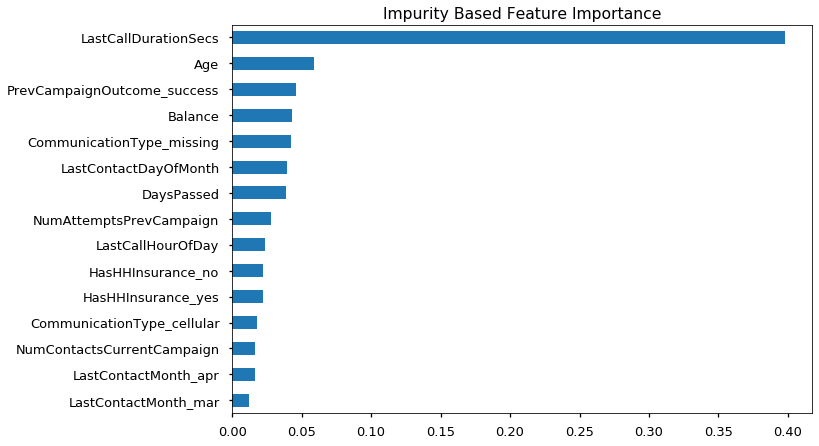

In [12]:
tree_feat_imp = pd.Series(rf.feature_importances_, index=feature_names)
tree_feat_imp.nlargest(15).sort_values().plot(
    kind="barh", title="Impurity Based Feature Importance"
)

##### Permutation feature importance

**On the validation set**

In [ ]:
permutation_feat_imp_valid = permutation_importance(
    rf, X_valid, y_valid, n_repeats=10, n_jobs=-1
)

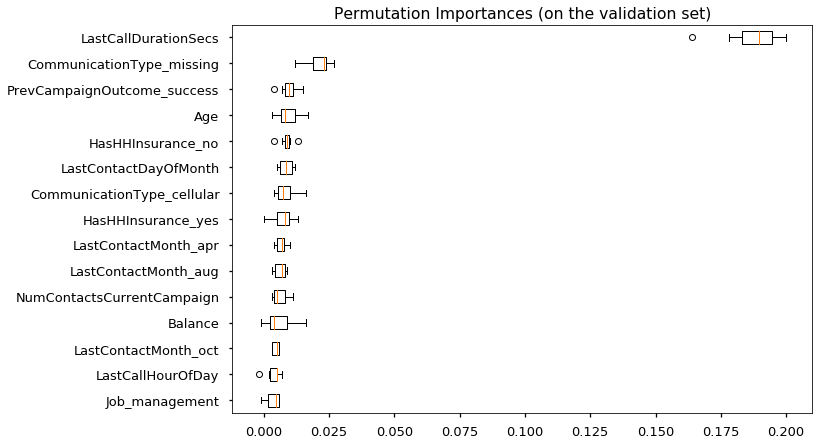

In [14]:
sorted_idx = permutation_feat_imp_valid.importances_mean.argsort()[-15:]

fig, ax = plt.subplots()
ax.boxplot(
    permutation_feat_imp_valid.importances[sorted_idx].T,
    vert=False,
    labels=feature_names[sorted_idx],
)
ax.set_title("Permutation Importances (on the validation set)")
plt.show()

**On the training set**

In [ ]:
permutation_feat_imp_train = permutation_importance(
    rf, X_train, y_train, n_repeats=10, n_jobs=-1
)

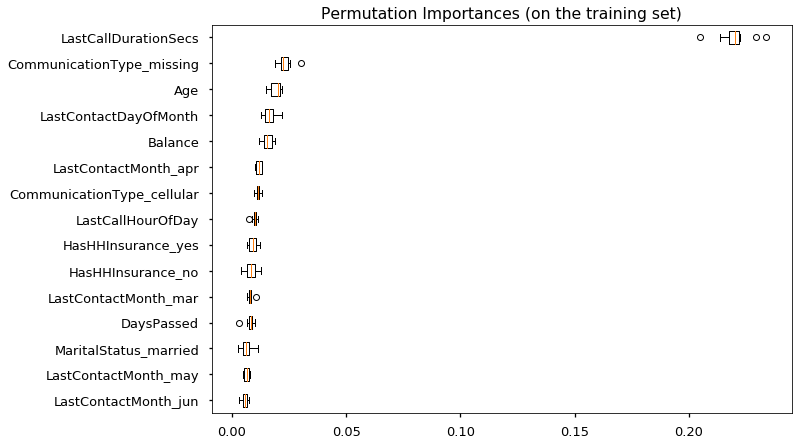

In [16]:
sorted_idx = permutation_feat_imp_train.importances_mean.argsort()[-15:]

fig, ax = plt.subplots()
ax.boxplot(
    permutation_feat_imp_train.importances[sorted_idx].T,
    vert=False,
    labels=feature_names[sorted_idx],
)
ax.set_title("Permutation Importances (on the training set)")
plt.show()

#### Partial Dependence Plots

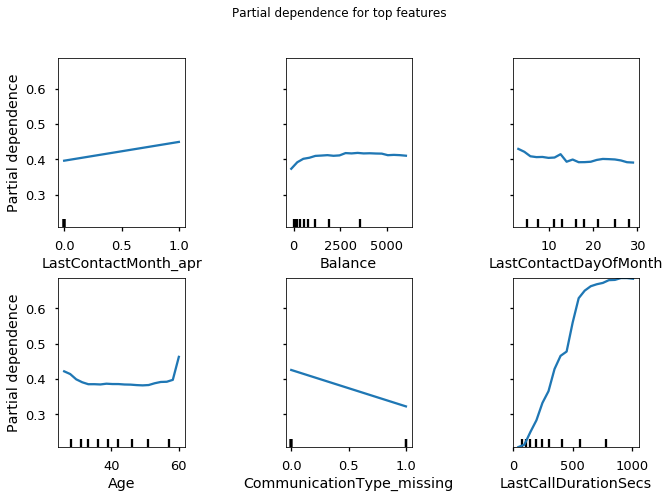

In [17]:
pdp_features = feature_names[sorted_idx][-6:]
plot_partial_dependence(
    rf, X_valid, features=pdp_features, feature_names=feature_names, grid_resolution=20
)
fig = plt.gcf()
fig.suptitle("Partial dependence for top features")
fig.subplots_adjust(wspace=0.8, hspace=0.3)

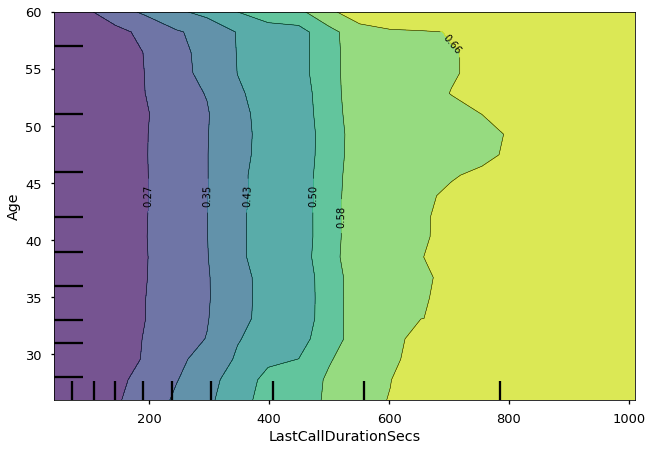

In [18]:
plot_partial_dependence(
    rf,
    X_valid,
    features=[("LastCallDurationSecs", "Age")],
    feature_names=feature_names,
    grid_resolution=20,
)

##### ALE Plots

In [19]:
from alepython.ale import ale_plot

In [20]:
train_df = pd.DataFrame(X_train, columns=feature_names).astype({feat: int for feat in cat_feature_names})
valid_df = pd.DataFrame(X_valid, columns=feature_names).astype({feat: int for feat in cat_feature_names})

Quantiles : [   5.    71.9  104.8  140.7  193.   243.   317.8  430.9  596.6  809.6
 2775. ]


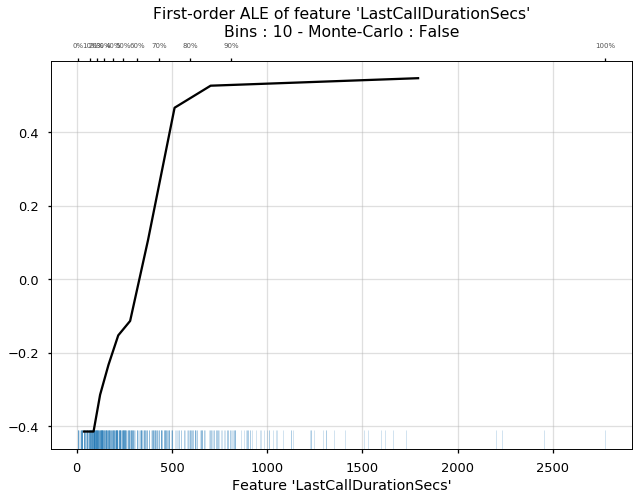

In [21]:
ale_plot(rf, valid_df.sample(500), "LastCallDurationSecs", monte_carlo=False)

##### StratPD

###### Numerical features

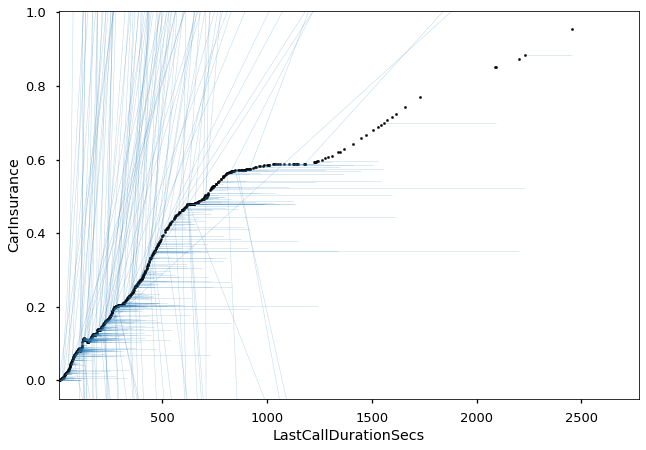

In [22]:
plot_stratpd(valid_df, y_valid, "LastCallDurationSecs", "CarInsurance", min_samples_leaf=5);

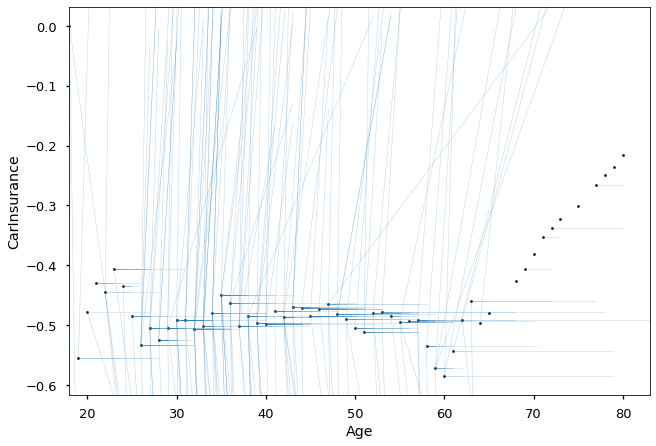

In [23]:
plot_stratpd(valid_df, y_valid, "Age", "CarInsurance", min_samples_leaf=10);

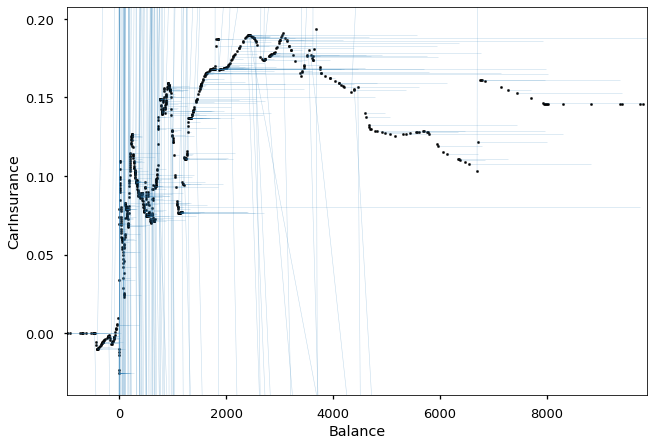

In [24]:
idx = (valid_df["Balance"] <= 10000).values
plot_stratpd(valid_df[idx], y_valid[idx], "Balance", "CarInsurance", min_samples_leaf=10);

###### Categorical features

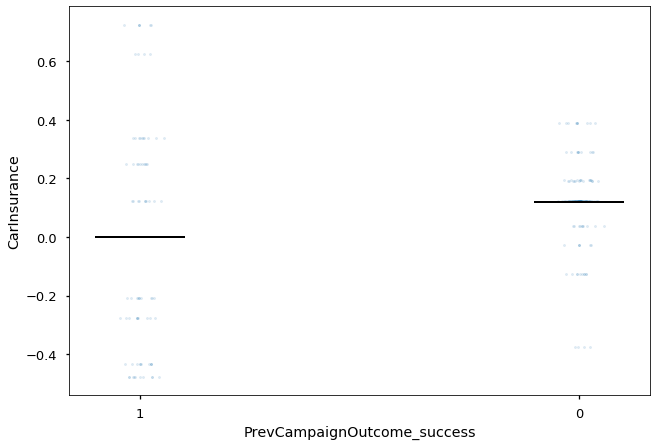

In [25]:
plot_catstratpd(valid_df, y_valid, "PrevCampaignOutcome_success", "CarInsurance", min_samples_leaf=20, ntrees=10);

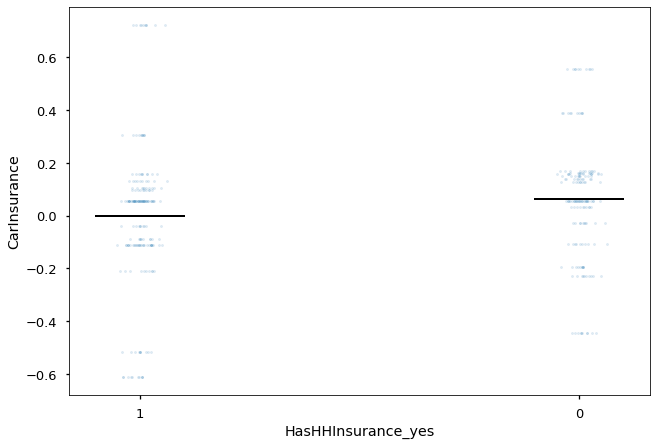

In [26]:
plot_catstratpd(valid_df, y_valid, "HasHHInsurance_yes", "CarInsurance", min_samples_leaf=20, ntrees=10);